In [49]:
%matplotlib inline
#posteior distribution of binomial data
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits
import scipy.special as special

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 


def loadData(filename):
    '''
    Read fits data
    
    '''
    tchfits = fits.open(filename)
    tabl = tchfits[1].data
    return tabl

# star/galaxy ratio in a small field of sky
filename = 'sdss_field.fits'
sdss = loadData(filename)

types = sdss.type
J = 13
#
observs = np.zeros((J,2))
for j in range(J):
    t0 = types[(j*50):np.min([(j*50+50),len(types)])]    
    observs[j,:] = np.array([np.float(np.sum(t0==3)),len(t0)])
    print 'No.%(d0)d: N_star=%(d1).0f, N_all=%(d2)d\n' %\
        {'d0':j,'d1':observs[j,0],'d2':observs[j,1]}


No.0: N_star=28, N_all=50

No.1: N_star=33, N_all=50

No.2: N_star=31, N_all=50

No.3: N_star=34, N_all=50

No.4: N_star=39, N_all=50

No.5: N_star=32, N_all=50

No.6: N_star=40, N_all=50

No.7: N_star=33, N_all=50

No.8: N_star=29, N_all=50

No.9: N_star=32, N_all=50

No.10: N_star=26, N_all=50

No.11: N_star=34, N_all=50

No.12: N_star=26, N_all=43



In [50]:
#point estimate
E_theta = np.mean(observs[:-1,0]/observs[:-1,1])
D_theta = np.var(observs[:-1,0]/observs[:-1,1])
print 'point estimates using the first 12 observations'
print 'E(theta)=%(e).5f,\tD(theta)=%(v).5f' %\
    {'e':E_theta, 'v':D_theta}

beta = (E_theta*(1-E_theta)/D_theta-1)*(1-E_theta)
alpha = E_theta*beta/(1-E_theta)
print '\nEstimates for the parameters of the prior density'
print 'alpha=%(a).5f,\tbeta=%(b).5f' % {'a':alpha, 'b':beta}

point estimates using the first 12 observations
E(theta)=0.65167,	D(theta)=0.00603

Estimates for the parameters of the prior density
alpha=23.87784,	beta=12.76334


Parameters of te posterior density
E(theta)=0.62628,	stD(theta)=0.05387


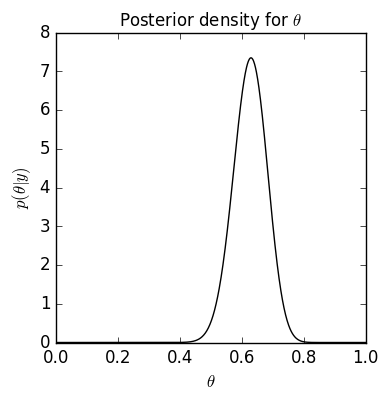

In [44]:
y = observs[-1,0]
n = observs[-1,1]
alpha_post = alpha+y
beta_post = beta+n-y
E_theta_post = alpha_post/(alpha_post+beta_post)
D_theta_post = alpha_post*beta_post/\
    ((alpha_post+beta_post)**2*(alpha_post+beta_post+1))
print 'Parameters of te posterior density'
print'E(theta)=%(e).5f,\tstD(theta)=%(v).5f' % \
    {'e':E_theta_post, 'v':np.sqrt(D_theta_post)}
theta = np.arange(0,1,0.001)
p = stats.beta.pdf(theta,alpha_post, beta_post)

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.plot(theta,p,'k-')
ax.set_xlabel(r'$\theta$',fontsize=12)
ax.set_ylabel(r'$p(\theta|y)$',fontsize=12)
ax.set_title(r'Posterior density for $\theta$',fontsize=12)
fig.show()

In [61]:
print np.log(alpha/beta),np.log(alpha+beta)

0.626373308021 3.60117272215


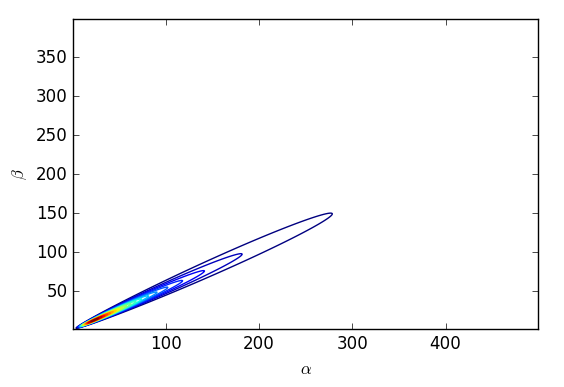

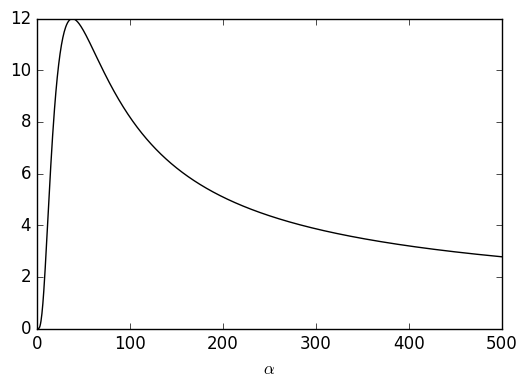

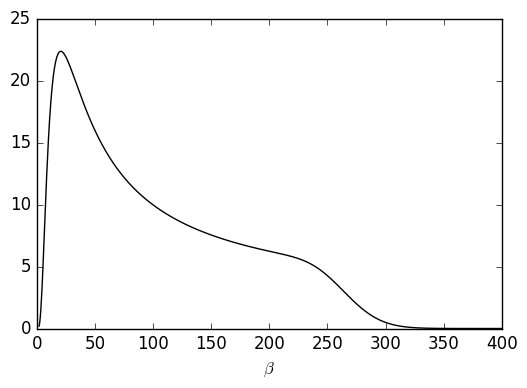

In [120]:
#Bayesian model
def posteriorln(x,y,n):
    alpha = x[0]
    beta = x[1]
    lnlikeli = 0.
    for j in range(len(y)):
        lnlikeli += special.gammaln(alpha+beta)+\
            special.gammaln(alpha+y[j])+\
            special.gammaln(beta+n[j]-y[j])-\
            special.gammaln(alpha)-special.gammaln(beta)-\
            special.gammaln(alpha+beta+n[j])
    priorln = np.log(beta)-5./2.*np.log(alpha+beta)
    return lnlikeli+priorln+395.

def draw_posterior(y,n,alphagrid,betagrid):
    p = np.zeros((len(alphagrid),len(betagrid)))
    for i in range(len(alphagrid)):
        for j in range(len(betagrid)):
            p[i,j] = posteriorln([alphagrid[i],betagrid[j]],y,n)
    return p



alphagrid = np.arange(1,500,0.5)
betagrid = np.arange(2,400,0.5)
p = draw_posterior(observs[:-1,0],observs[:-1,1],\
        alphagrid,betagrid)

fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(alphagrid,betagrid)
ax.contour(amesh, bmesh, np.exp(p.T),20,\
            extent=[alphagrid[0],\
            alphagrid[-1],betagrid[0],betagrid[-1]])
ax.set_xlabel(r'$\alpha$',fontsize=12)
ax.set_ylabel(r'$\beta$',fontsize=12)

fig.show()

fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(alphagrid,betagrid)
ax.plot(alphagrid, np.sum(np.exp(p), axis=1),'k-')
ax.set_xlabel(r'$\alpha$',fontsize=12)

fig.show()
        
fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(alphagrid,betagrid)
ax.plot(betagrid, np.sum(np.exp(p), axis=0),'k-')
ax.set_xlabel(r'$\beta$',fontsize=12)

fig.show()

In [93]:
np.max(p)
np.log(25+14)

3.6635616461296463

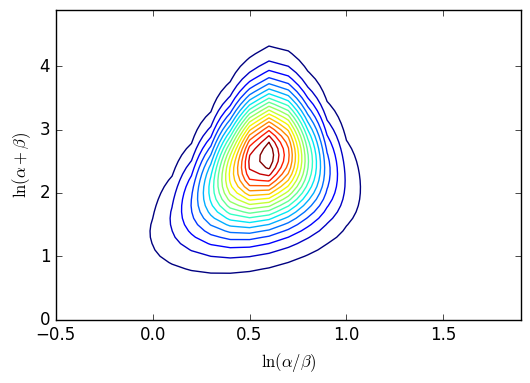

In [125]:
def draw_posteriorln(y,n,agrid,bgrid):
    p = np.zeros((len(agrid),len(bgrid)))
    for i in range(len(agrid)):
        for j in range(len(bgrid)):
            alpha = np.exp(agrid[i]+bgrid[j])/(1+np.exp(agrid[i]))
            beta = np.exp(bgrid[j])/(1+np.exp(agrid[i]))
            #print alpha,beta
            Jacob_detln = -np.log(alpha)-np.log(beta)
            p[i,j] = posteriorln([alpha,beta],y,n)+Jacob_detln
    return p

agrid = np.arange(-0.5,2,0.1)
bgrid = np.arange(0,5,0.1)
p2 = draw_posteriorln(observs[:-1,0],observs[:-1,1],\
        agrid,bgrid)

fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(agrid,bgrid)
ax.contour(amesh, bmesh, np.exp(p2.T-7.34),20,\
            extent=[alphagrid[0],\
            alphagrid[-1],betagrid[0],betagrid[-1]])
ax.set_xlim([-0.5,2])
ax.set_ylim([0,5])
ax.set_xlabel(r'$\ln(\alpha/\beta)$',fontsize=12)
ax.set_ylabel(r'$\ln(\alpha+\beta)$',fontsize=12)

fig.show()

mean(alpha|y)=9.17608	mean(beta|y)=5.06795


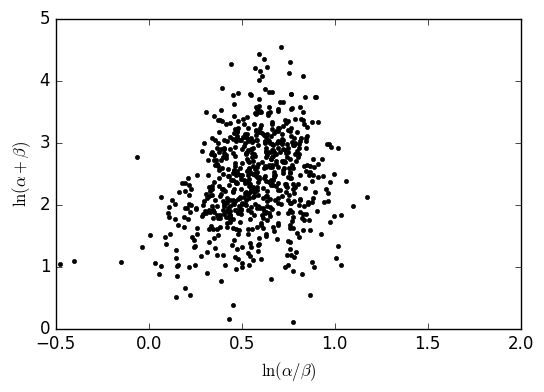

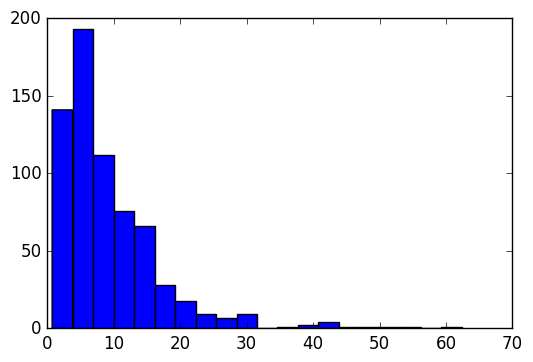

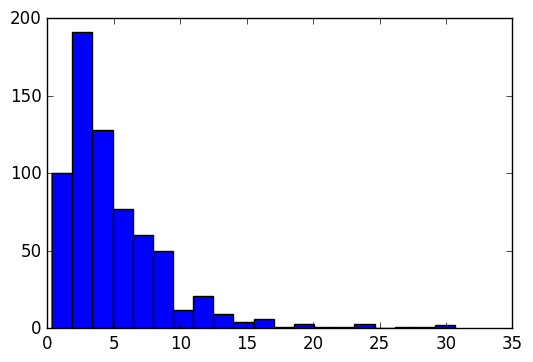

In [137]:
#sample random values from p(ln(a/b),ln(a+b))
N = 10000
a0 = np.random.uniform(-0.5,2,size=N)
b0 = np.random.uniform(0,5,size=N)
p0 = np.random.uniform(0,0.0117,size=N)
alpha0 = np.exp(a0+b0)/(1+np.exp(a0))
beta0 = np.exp(b0)/(1+np.exp(a0))
Jacob_detln = -np.log(alpha0)-np.log(beta0)
p = np.exp([posteriorln([alpha0[i],beta0[i]],\
    observs[:-1,0],observs[:-1,1])+Jacob_detln[i] \
    for i in range(N)])
ind = (p0<=p)
a = a0[ind]
b = b0[ind]
alpha = alpha0[ind]
beta = beta0[ind]

print 'mean(alpha|y)=%(a).5f\tmean(beta|y)=%(b).5f' %\
    {'a': np.mean(alpha),'b': np.mean(beta)}
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(a,b,'k.')
ax.set_xlim([-0.5,2])
ax.set_ylim([0,5])
ax.set_xlabel(r'$\ln(\alpha/\beta)$',fontsize=12)
ax.set_ylabel(r'$\ln(\alpha+\beta)$',fontsize=12)
fig.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(alpha,20)
fig.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(beta,20)
fig.show()


mean(theta|alpha,beta,y)=0.65196
std(theta|alpha,beta,y)=0.01679


/Users/cliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


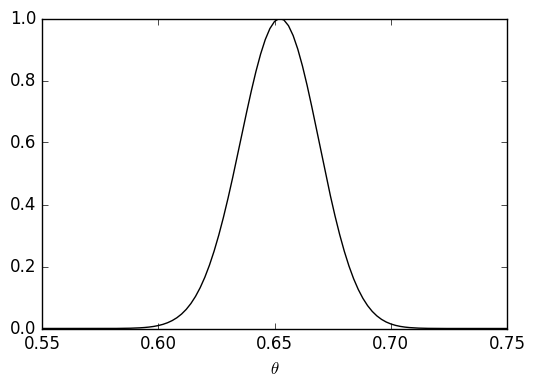

In [149]:
#predict post density of theta
theta = np.arange(0,1,0.002)
pln = np.zeros(np.shape(theta))
for j in range(13):
    a = np.mean(alpha)+observs[j,0]
    b = np.mean(beta)+observs[j,1]-observs[j,0]
    pln = pln+np.log(stats.beta.pdf(theta,a,b))

p = np.exp(pln-np.max(pln))

mean_theta_post = np.sum(p*theta)/np.sum(p)
std_theta_post = np.sqrt(np.sum(p*(theta-\
    mean_theta_post)**2)/np.sum(p))
print 'mean(theta|alpha,beta,y)=%(p).5f' %\
    {'p':mean_theta_post}
print 'std(theta|alpha,beta,y)=%(p).5f' %\
    {'p':std_theta_post}
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(theta,p,'k-')
ax.set_xlabel(r'$\theta$',fontsize=12)
ax.set_xlim([0.55,0.75])
fig.show()


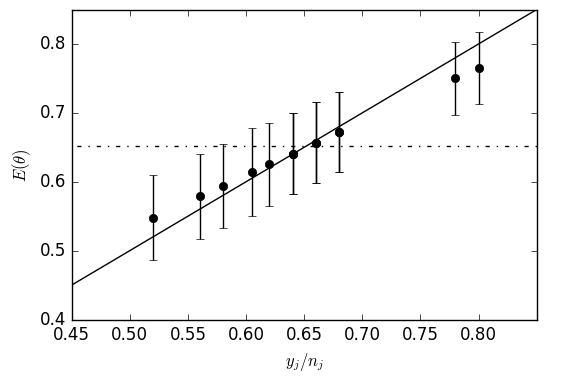

In [148]:

#estimate theta_j from the given mean alpha and beta
p_theta_post = np.zeros((13,2))
for j in range(13):
    a = np.mean(alpha)+observs[j,0]
    b = np.mean(beta)+observs[j,1]-observs[j,0]
    p_theta_post[j,0] = a/(a+b)
    p_theta_post[j,1] =np.sqrt(a*b/((a+b)**2*(a+b+1)))

    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(observs[:,0]/observs[:,1],p_theta_post[:,0],\
    yerr=p_theta_post[:,1],fmt='ko')
ax.plot([0.45,0.85],[0.45,0.85],'-k')
ax.plot([0,1],[mean_theta_post,mean_theta_post],'k-.')
ax.set_xlabel(r'$y_j/n_j$',fontsize=12)
ax.set_ylabel(r'$E(\theta)$',fontsize=12)
ax.set_xlim([0.45,0.85])

fig.show()

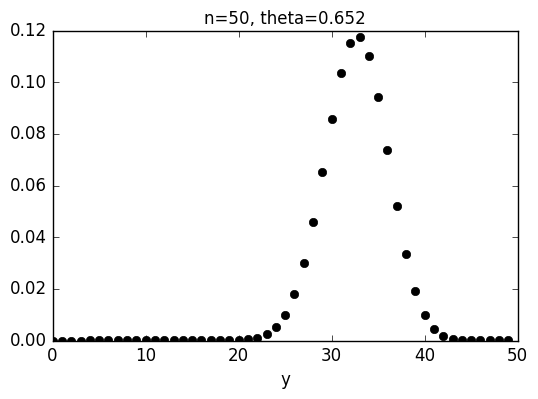

In [156]:
#predict next y from posterior theta
y = np.arange(0,50,1)
p_y = stats.binom.pmf(y,50,mean_theta_post)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y,p_y,'ko')
ax.set_xlabel('y',fontsize=12)
ax.set_title('n=50, theta=%(t).3f' % {'t': mean_theta_post})

fig.show()